In [2]:
# Import the necessary dependencies

# Operating System
import os

# Numpy, Pandas and Scipy
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, save_npz, load_npz,csc_matrix

# Scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Model Evaluation
from evaluation import evaluate

# Submtion Evaluation
from validate_sample_submission import validate_submission

# 1: Import and exploratory analysis

#### BOOK RATING

In [3]:
#reading and analising book rating information

bookratings = pd.read_csv('data/BookRatings.csv')
print(bookratings.shape)
bookratings.head()

bookratings['Book-Rating'].value_counts(dropna=False) #from 1 to 10 and no missing values

bookratings['User-ID'].nunique() #5719
bookratings_users = bookratings['User-ID'].unique()

bookratings['ISBN'].nunique() #47768

bookratings[['User-ID','ISBN']].drop_duplicates() #there are no duplicates - 109209 rows × 2 columns

bookratings.head()

(109209, 3)


,User-ID,ISBN,Book-Rating
0,99,0316748641,7
1,99,0446677450,10
2,99,0553347594,9
3,99,0451166892,3
4,99,0671621009,10


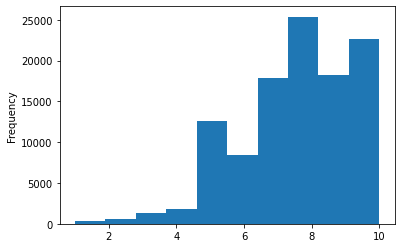

In [4]:
bookratings['Book-Rating'].plot.hist()

#### TEST USERS

In [5]:
#reading and analising test users table

test_users = pd.read_csv('data/test_users.csv')
print(test_users.shape)

test_users['User-ID'].nunique() #there are no duplicates
test_users.head()

(589, 1)


,User-ID
0,114
1,507
2,850
3,3346
4,4092


In [6]:
# counting users that are already client and new prospects
test_users.isin(bookratings_users).sum(axis=0) #489

# list of clients with rating information
test_users_clients = test_users[test_users.isin(bookratings_users)].dropna().reset_index() #489

# list of new prospects
test_users_new = test_users[~test_users.isin(bookratings_users)].dropna().reset_index() #100
test_users_new

,index,User-ID
0,7,5490.0
1,11,8454.0
2,18,12569.0
3,28,15185.0
4,31,17003.0
...,...,...
95,566,272715.0
96,567,273190.0
97,571,274056.0
98,586,277901.0


#### BOOKS META INFO

In [7]:
booksmetainfo = pd.read_csv('data/BooksMetaInfo.csv')

booksmetainfo.shape #(112341, 12)
booksmetainfo.head(1)

/home/fernandamcohen/.virtualenvs/hckt05/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,description,pageCount,categories
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,"['Mark P. O. Morford', 'Robert J. Lenardon']",Provides an introduction to classical myths pl...,808.0,['Social Science']


#### BOOKS USERS

,User-ID,Location,Age
0,2,"stockton, california, usa",18.0
1,8,"timmins, ontario, canada",NaN


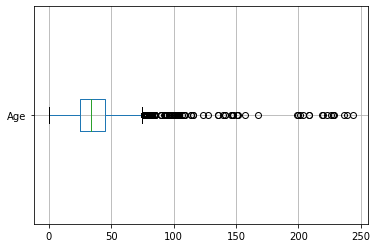

In [8]:
booksusers = pd.read_csv('data/BooksUsers.csv')
booksusers.shape #(61568, 3)

# booksusers['Age'].plot.hist(bins=20)
#NaN      24605

pd.DataFrame(booksusers.Age).boxplot(vert=False);

booksusers.head(2)


In [38]:
booksusers.Location.nunique()

16795

# 2: Non-personalised recommendation

In [9]:
def make_ratings(data):
    """Creates the ratings matrix of listening history with optional shape
    
    Creates the ratings matrix from the listening history imported using the read_users_history() method.
    
    Args:
        data (pd.DataFrame):  Listening history for the users.
        shape (tuple): The overall (n_users, n_items) shape desired for the matrix. 
                       If None, define the shape with the (n_users, n_items) from data argument.
        
    Returns:
        ratings (csr_matrix): Ratings matrix with shape (n_users, n_items).
    
    """
    users, user_pos = np.unique(data.iloc[:, 0].values, return_inverse=True)
    items, item_pos = np.unique(data.iloc[:, 1].values, return_inverse=True)
    values = data.iloc[:, 2].fillna(0).values
    
    #R Matrix dimensions (n_users, n_items)
    shape = (len(users), len(items))

    R_ = csr_matrix((values, (user_pos, item_pos)), shape=shape)
    
    R_ = pd.DataFrame(data).pivot(index='User-ID', columns='ISBN', values="Book-Rating")
    
    return R_



def make_train_val_split(data, test_size = 0.2):
    """Split the data into train and validation and returns the ratings matrixes accordingly.
    
    Args:
        data (pd.DataFrame): Listening history for the users.
        test_size (float): Percentage of listening history used for validation.
    
    Returns:
        ratings_train (csr_matrix): Ratings matrix for train.
        ratings_val (csr_matrix): Ratings matrix for validation.
    
    """
    train_data, val_data = train_test_split(data, test_size=test_size, random_state=8)

    #Store the indexes of each observation to identify which records to replace with zero
    train_index = train_data.index
    val_index = val_data.index

    #make copies of data to replace the observations
    train_data_clean = data.copy()
    val_data_clean = data.copy()

    #Replace the validation observations on the training data
    train_data_clean.loc[val_index,["Book-Rating"]] = 0
    
    #Replace the training observations on the validation data
    val_data_clean.loc[train_index,["Book-Rating"]] = 0

    #Create the R matrices
    R_train = make_ratings(train_data_clean)
    R_val = make_ratings(val_data_clean)

    #remove the explicit zeros from the sparse matrices
#     R_train.eliminate_zeros()
#     R_val.eliminate_zeros()

    return R_train, R_val


In [10]:
#creating traning and validation sets

test_size = 0.2

ratings_train, ratings_val = make_train_val_split(bookratings, test_size=test_size)

ratings_train.shape #(5719, 47768)
ratings_val.shape #(5719, 47768)


(5719, 47768)

In [11]:
type(ratings_train)

pandas.core.frame.DataFrame

### Average rating and quantity of rating per book

In [12]:
#rating average
avg_books = ratings_train[ratings_train>0].mean(axis=0).sort_values(ascending=False) #(47768,)

In [13]:
#ranting count
count_books = np.greater(ratings_train.fillna(0), 0).sum(axis=0)

ISBN
9997508769    10.0
0743247183    10.0
074342736X    10.0
0743424239    10.0
0743423712    10.0
              ... 
9838120014     NaN
9839154125     NaN
987906500X     NaN
9971400162     NaN
9997507002     NaN
Length: 47768, dtype: float64

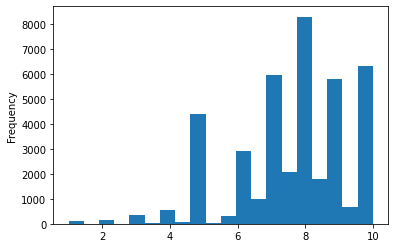

In [14]:
avg_books.shape
avg_books.plot.hist(bins=20);

#NaN          6817
#avg_books.value_counts(dropna=False)

avg_books

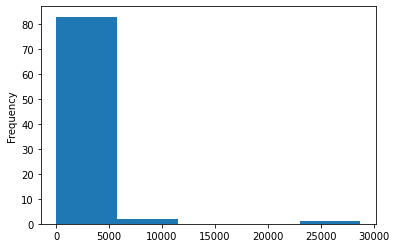

In [15]:
count_books.value_counts(dropna=False).plot.hist(bins=5);

In [16]:
non_pers_mean = pd.merge(pd.DataFrame(count_books, columns=['qtd']), pd.DataFrame(avg_books, columns=['avg']), on='ISBN').dropna()
#(40951, 2)

In [17]:
non_pers_mean_gt10 = non_pers_mean[non_pers_mean['qtd']>10].sort_values(by='avg', ascending=False) #(969, 2)

In [18]:
print(non_pers_mean_gt10.shape)
non_pers_mean_gt10.head()

(969, 2)


,qtd,avg
ISBN,,
0439425220,17,9.882353
0836218221,15,9.666667
0345339738,35,9.657143
006440188X,14,9.571429
0064409422,11,9.545455


### Select the 10 best rated for each user

#### 1 - new users

In [19]:
list_new_top10 = np.array(non_pers_mean[non_pers_mean['qtd']>50].sort_values(by='avg', ascending=False)[:10].index)
non_pers_mean[non_pers_mean['qtd']>50].sort_values(by='avg', ascending=False)[:10]
# type(list_new_top10)

,qtd,avg
ISBN,,
0439139597,70,9.228571
0446310786,85,9.094118
043935806X,97,9.092784
0590353403,61,9.016393
0345342968,63,9.000000
0439064864,68,8.985294
0439136369,53,8.981132
059035342X,118,8.966102
0345339681,62,8.822581


In [20]:
# type(test_users_new)
baseline_new = pd.DataFrame(test_users_new.copy())
baseline_new['chave']=1
baseline_new

list_new_top10_df = pd.DataFrame(list_new_top10, columns=['ISBN'])
list_new_top10_df['chave']=1
list_new_top10_df

# for i in list_new_top10:
#     baseline_new[i] = i
    
baseline_new = pd.merge(baseline_new,list_new_top10_df,on='chave', how='left').drop('chave',axis=1)
baseline_new

,index,User-ID,ISBN
0,7,5490.0,0439139597
1,7,5490.0,0446310786
2,7,5490.0,043935806X
3,7,5490.0,0590353403
4,7,5490.0,0345342968
...,...,...,...
995,587,278137.0,0439064864
996,587,278137.0,0439136369
997,587,278137.0,059035342X
998,587,278137.0,0345339681


#### 2 - clients

In [21]:
# I need create a list per user

list_clients = np.array(non_pers_mean[non_pers_mean['qtd']>10].sort_values(by='avg', ascending=False).index)
len(list_clients)

baseline_client = pd.DataFrame(columns=['User-ID','ISBN'])

for i in range(0,489):
    list_read = ratings_train.loc[test_users_clients.iloc[i][1]].dropna().index.to_list()
    
    pos_aux=0
    list_user = []
    while len(list_user) < 10:
        pos_aux=pos_aux+1
        
        if list_clients[pos_aux] not in list_read:
#             print(list_clients[pos_aux])
#             print(list_read)
            list_user.append(list_clients[pos_aux])
    
    
    aux_client = pd.DataFrame(pd.Series(test_users_clients.iloc[i][1]), columns=['User-ID'])
    aux_client['chave']=1

    list_top10_df = pd.DataFrame(list_user, columns=['ISBN'])
    list_top10_df['chave']=1
    
        
    aux_client = pd.merge(aux_client,list_top10_df,on='chave', how='left').drop('chave',axis=1)
    baseline_client = baseline_client.append(aux_client)        
        
        
    
# test_users_clients.iloc[0][1]



In [22]:
baseline_client.ISBN.nunique()

12

In [23]:
baseline = baseline_client.append(baseline_new)
baseline['User-ID']=baseline['User-ID'].map(int)

In [24]:
baseline.ISBN.nunique()#21
baseline['User-ID'].nunique()#589
baseline = baseline.drop('index',axis=1)
baseline.head()

,User-ID,ISBN
0,114,0836218221
1,114,0345339738
2,114,006440188X
3,114,0064409422
4,114,0060256672


### Evaluation

#### 1 - predictions on validation set

In [25]:
baseline_evaluation = pd.DataFrame(ratings_val.index, columns=['User-ID'])

list_new_top10

j=0
for i in list_new_top10:
    baseline_evaluation[j] = i
    j=j+1
    
baseline_evaluation = baseline_evaluation.set_index('User-ID').sort_index()
baseline_evaluation

,0,1,2,3,4,5,6,7,8,9
User-ID,,,,,,,,,,
99,0439139597,0446310786,043935806X,0590353403,0345342968,0439064864,0439136369,059035342X,0345339681,0380002930
114,0439139597,0446310786,043935806X,0590353403,0345342968,0439064864,0439136369,059035342X,0345339681,0380002930
243,0439139597,0446310786,043935806X,0590353403,0345342968,0439064864,0439136369,059035342X,0345339681,0380002930
244,0439139597,0446310786,043935806X,0590353403,0345342968,0439064864,0439136369,059035342X,0345339681,0380002930
254,0439139597,0446310786,043935806X,0590353403,0345342968,0439064864,0439136369,059035342X,0345339681,0380002930
...,...,...,...,...,...,...,...,...,...,...
278554,0439139597,0446310786,043935806X,0590353403,0345342968,0439064864,0439136369,059035342X,0345339681,0380002930
278582,0439139597,0446310786,043935806X,0590353403,0345342968,0439064864,0439136369,059035342X,0345339681,0380002930
278633,0439139597,0446310786,043935806X,0590353403,0345342968,0439064864,0439136369,059035342X,0345339681,0380002930


In [26]:
def create_dict_preds(preds_df: pd.DataFrame) -> dict:
    """Convert the predictions DataFrame (index:users -> columns: items) to a dictionary of key (user->list of items).
    
    Args: 
        preds_df (pd.DataFrame): DataFrame containing the users and the ordered predictions.
        
    Returns:
        preds_dict (dict): Dict of (user_id: list of items) used for evaluating the performance.
    
    """
    return {preds_df.index[i]: preds_df.values[i].tolist() for i in range(len(preds_df))}

In [27]:
non_pers_dict = create_dict_preds(baseline_evaluation)
non_pers_dict

{99: ['0439139597',
  '0446310786',
  '043935806X',
  '0590353403',
  '0345342968',
  '0439064864',
  '0439136369',
  '059035342X',
  '0345339681',
  '0380002930'],
 114: ['0439139597',
  '0446310786',
  '043935806X',
  '0590353403',
  '0345342968',
  '0439064864',
  '0439136369',
  '059035342X',
  '0345339681',
  '0380002930'],
 243: ['0439139597',
  '0446310786',
  '043935806X',
  '0590353403',
  '0345342968',
  '0439064864',
  '0439136369',
  '059035342X',
  '0345339681',
  '0380002930'],
 244: ['0439139597',
  '0446310786',
  '043935806X',
  '0590353403',
  '0345342968',
  '0439064864',
  '0439136369',
  '059035342X',
  '0345339681',
  '0380002930'],
 254: ['0439139597',
  '0446310786',
  '043935806X',
  '0590353403',
  '0345342968',
  '0439064864',
  '0439136369',
  '059035342X',
  '0345339681',
  '0380002930'],
 300: ['0439139597',
  '0446310786',
  '043935806X',
  '0590353403',
  '0345342968',
  '0439064864',
  '0439136369',
  '059035342X',
  '0345339681',
  '0380002930'],
 388:

#### 2 - ground truth

In [28]:
# I will get the 10 books with hightest rating per user in the validation set

train_data, val_data = train_test_split(bookratings, test_size=0.2, random_state=8)
val_index = val_data.index
train_index = train_data.index
val_data_clean = bookratings.copy()
#Replace the training observations on the validation data
val_data_clean.loc[train_index,["Book-Rating"]] = 0

users, user_pos = np.unique(val_data_clean.iloc[:, 0].values, return_inverse=True)
items, item_pos = np.unique(val_data_clean.iloc[:, 1].values, return_inverse=True)
values = val_data_clean.iloc[:, 2].fillna(0).values

#R Matrix dimensions (n_users, n_items)
shape = (len(users), len(items))

R_ratings_val = csr_matrix((values, (user_pos, item_pos)), shape=shape)
    
R_ratings_val

<5719x47768 sparse matrix of type '<class 'numpy.int64'>'
	with 109209 stored elements in Compressed Sparse Row format>

In [29]:
top_from_R_val = pd.DataFrame(np.negative(R_ratings_val).toarray().argsort()[:, :10]) #return indexes

In [36]:
R_ratings_val.toarray().shape

(5719, 47768)

In [ ]:
top_from_R_val

In [114]:
y_true_df=pd.concat([pd.DataFrame(ratings_val.index, columns=['User-ID']), top_from_R_val], axis=1)
y_true_dict = create_dict_preds(y_true_df.set_index('User-ID'))

#### 3 - evaluation


In [78]:
non_pers_dict

{99: ['0439139597',
  '0446310786',
  '043935806X',
  '0590353403',
  '0345342968',
  '0439064864',
  '0439136369',
  '059035342X',
  '0345339681',
  '0380002930'],
 114: ['0439139597',
  '0446310786',
  '043935806X',
  '0590353403',
  '0345342968',
  '0439064864',
  '0439136369',
  '059035342X',
  '0345339681',
  '0380002930'],
 243: ['0439139597',
  '0446310786',
  '043935806X',
  '0590353403',
  '0345342968',
  '0439064864',
  '0439136369',
  '059035342X',
  '0345339681',
  '0380002930'],
 244: ['0439139597',
  '0446310786',
  '043935806X',
  '0590353403',
  '0345342968',
  '0439064864',
  '0439136369',
  '059035342X',
  '0345339681',
  '0380002930'],
 254: ['0439139597',
  '0446310786',
  '043935806X',
  '0590353403',
  '0345342968',
  '0439064864',
  '0439136369',
  '059035342X',
  '0345339681',
  '0380002930'],
 300: ['0439139597',
  '0446310786',
  '043935806X',
  '0590353403',
  '0345342968',
  '0439064864',
  '0439136369',
  '059035342X',
  '0345339681',
  '0380002930'],
 388:

In [113]:
evaluate(y_true_dict, non_pers_dict)

0.0

### Export - 1st submission

In [30]:
validate_submission(baseline)

True

In [ ]:
baseline.to_csv('data/1st_submission.csv',index=False)

In [ ]:
baseline.info()